# Satellite observations completeness for monitor water resource management

Production date: 12-07-2024

Produced by: Cristina Deidda (VUB)

## 🌍 Use case: Utilize satellite-derived lake water temperature data to water resources management and support climate adaptation strategies

## ❓ Quality assessment question
* **Are satellite measurements of surface water temperature adequately comprehensive in terms of temporal coverage and data completeness to monitor the temperature dynamics of the Lake Superior (Nord America)?**

**The lake surface water temperature data from 1995 to the present, derived from satellite observations, provide a time series of water temperature for various lakes around the globe. This dataset can be utilized for multiple applications, such as water resource management to monitor water level temperature, adapting to climate change impacts, optimizing fisheries management, or monitoring ecosystem health. In this case study, we will focus on Lake Superior, considering the mean water surface temperature for the entire available time series. The objective is to study the completeness of the time series, the data quality, and the possible presence of outliers to determine the suitability of the data for the aforementioned applications.**

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The mean water lake temperature data for Lake Superior (North America) from 1997-2000 is incomplete.
* It is important to mask the data using 'quality flags' and only use data with quality flags >4, as recommended.
* Despite the missing data, the seasonal temperature variation is well represented.
* The quality of data depends on the case study and the lake considered. For some lakes, there may be less data available with a quality level higher than 4.
* This dataset has high potential for water resource management, prior considering the quality flags, missing values, and possible outliers.
```

For surface water level monitoring, it is important to check the completeness of the data series before applying any type of statistical analysis. In the case study of mean water lake temperature over Lake Superior (1997-2000), the data series is incomplete, with 54.31% of values missing. The data are provided with 'quality flags' ranging from 0 to 5, with a minimum quality level suggested for data usage.

Quality levels 4 and 5 reflect a higher degree of confidence in the validity of the satellite estimate. Users are advised to use the highest quality levels (4 and 5) in preference, unless they have specifically verified that lower quality levels are suitable for their application. Quality level 3 data, compared with in-situ data, may be acceptable to some users; however, they should be used with caution. Quality level 1 data should never be used as they are classified as "bad data," and quality level 2 data should be thoroughly inspected if their use is strictly necessary. For Lake Superior, the data quality is good, mostly higher than 4 for the entire lake surface (see section  4.2.4. of [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177) or section 3.4 of [ATBD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800127#LSWTv4.5:AlgorithmTheoreticalBasisDocument(ATBD)-DeterminingQualityLevel)).

A boxplot analysis reveals the presence of outliers in both the upper and lower parts of the data. By masking the data to include only those with quality flags higher than 4, the number of outliers is reduced. Despite the presence of missing values, the series effectively represents seasonal variation.

```{figure} attachment:bd326ec5-9501-4718-9e47-9c49bf51c43d.PNG
---
height: 150px
---
Figure 1: Spatially weighted mean of water temperature for Lake Superior, considering only data with quality flags of 4 or higher.
```
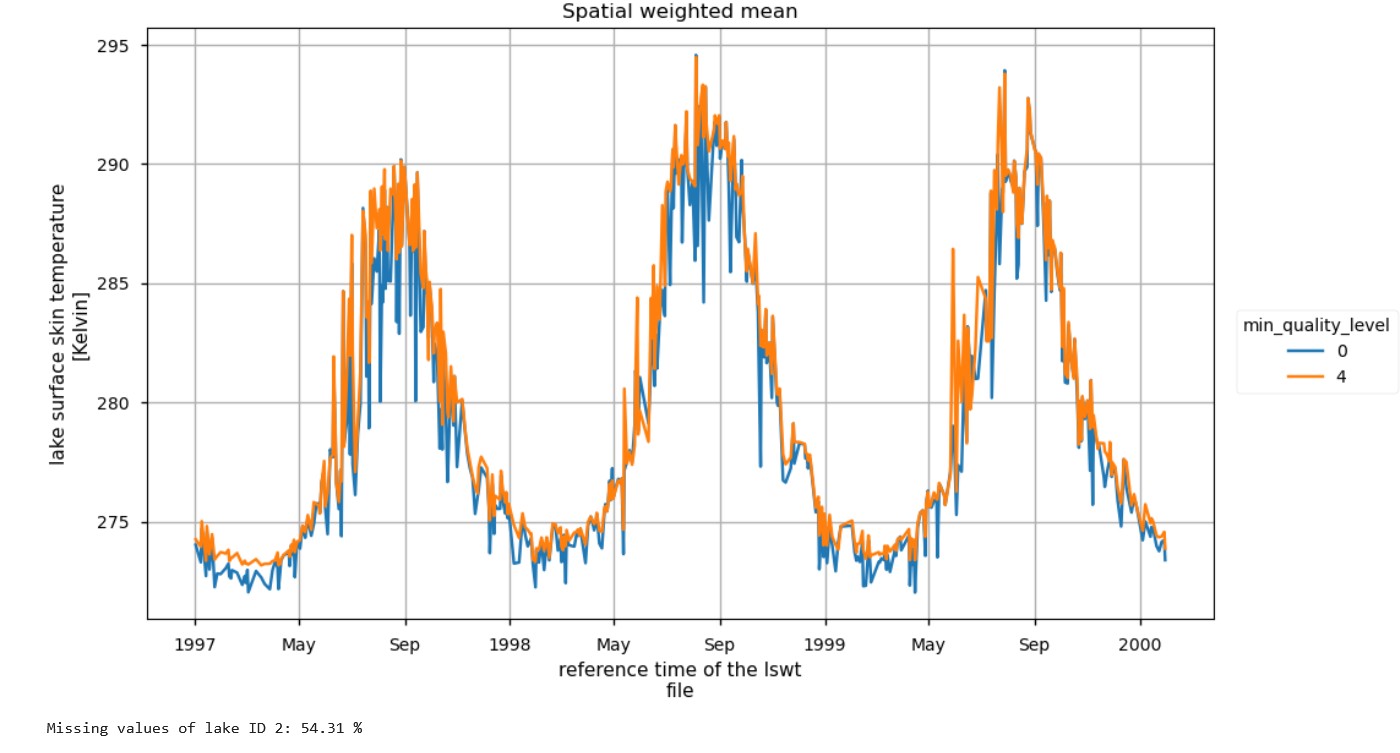

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download satellite water temperature data selecting boundary box of Lake Superior

**[](section-2)**
 * Plot Lake Superior and ID
 * Inspect the quality flags
 * Select the data with quality flags higher than 4
 * Calculate percentage of missing values
 * Plot time series for filtered and not filtered data
 * Boxplot for filtered (quality flag>4) and not filtered data
 

## 📈 Analysis and results

(section-1)=
### 1. Data request and download

#### Import packages
Import c3s_eqc_automatic_quality_control library and packages for statistical analysis

In [7]:
import cartopy.crs as ccrs
import matplotlib.cbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

#### Set variables
Set the start and end time of the analysis and the name of the variable. We selected the region of Lake Superior specifying the coordinates of the box area.

In [2]:
# Time
start = "1997-01"
stop = "2000-01"

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request
Set the request specifying version and format of the data.

In [3]:
collection_id = "satellite-lake-water-temperature"
request = {
    "version": "4.0",
    "variable": "all",
    "format": "zip",
}

#### Download data
Use download and transform, specifying the longitude and latitude of the selected area.

In [4]:
requests = download.update_request_date(
    request, start=start, stop=stop, stringify_dates=True
)
ds = download.download_and_transform(
    collection_id,
    requests,
    chunks={"year": 1, "month": 1},
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
)

100%|██████████| 37/37 [00:05<00:00,  6.43it/s]


(section-2)=
### 2. Results

#### Plot lakeid
Extract the lake id to identify the lake number

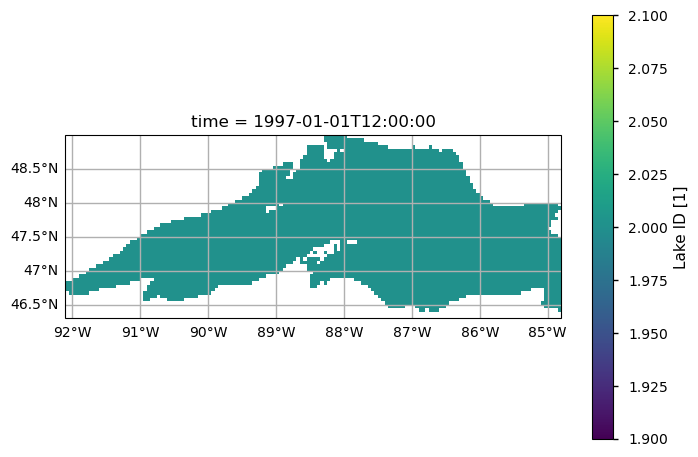

In [5]:
_ = plot.projected_map(
    ds["lakeid"].isel(time=0),
    projection=ccrs.PlateCarree(),
    show_stats=False,
)

In the dataset, the variable 'lake id' allows us to select the lake of interest. In our case, it is equal to 2 for Lake Superior.

#### Compute spatial weighted mean
Reindexing the dataset using lake ID and minimum quality level. Calculate the spatially weighted mean of the temperature from the filtered dataset.

In [8]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid"].values), dims=("lakeid"))
    .dropna("lakeid")
    .astype(int)
)
min_quality_level = xr.DataArray([0, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid").where(ds["lakeid"] == lakeid)
ds = ds.where(ds["quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid=lakeid, min_quality_level=min_quality_level)

# Spatial weighted mean
da = diagnostics.spatial_weighted_mean(ds[varname])

#### Plot spatial weighted mean
Plot the spatially weighted mean of lake surface temperature for the area considered. Display the data with and without quality level filtering.

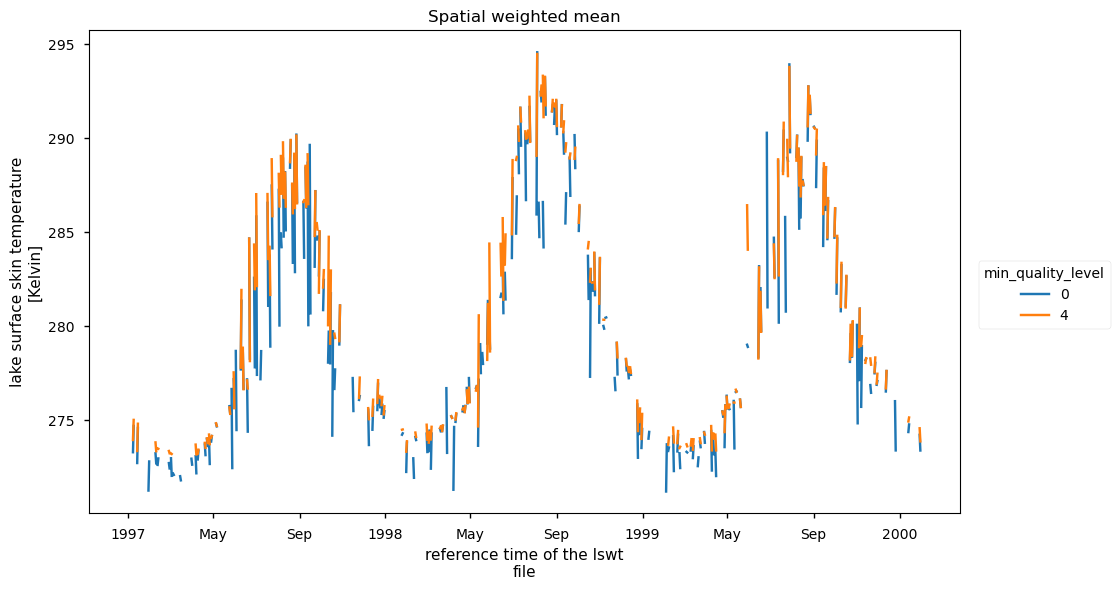

Minimum quality level 0: missing values lake ID 2 is 54.31 %
Minimum quality level 4: missing values lake ID 2 is 57.66 %


In [29]:
da.plot(hue="min_quality_level", col="lakeid", figsize=(10, 6))
#plt.grid()
plt.title("Spatial weighted mean")
plt.show()

# Print missing values considering all data
missings = da.sel(min_quality_level=0).isnull().sum("time") / da.sizes["time"] * 100
for lakeid, missing in missings.groupby("lakeid", squeeze=False):
    print(f"Minimum quality level 0: missing values lake ID {lakeid} is {float(missing.squeeze()):.2f} %")

# Print missing values for quality level equal and more than 4
missings = da.sel(min_quality_level=4).isnull().sum("time") / da.sizes["time"] * 100
for lakeid, missing in missings.groupby("lakeid", squeeze=False):
    print(f"Minimum quality level 4: missing values lake ID {lakeid} is {float(missing.squeeze()):.2f} %")

The plot shows the spatially weighted mean of lake temperature, with all data (minimum quality level = 0) displayed in blue and data filtered to a minimum quality level of 4 shown in yellow. It is evident that filtering the data by quality flags results in fewer outliers. Despite the relatively high percentage of missing values, the seasonal variation in lake temperature is well represented.

#### Boxplot
Definition of boxplot to evaluate the presence of outlier in the series with and without filtering the data.

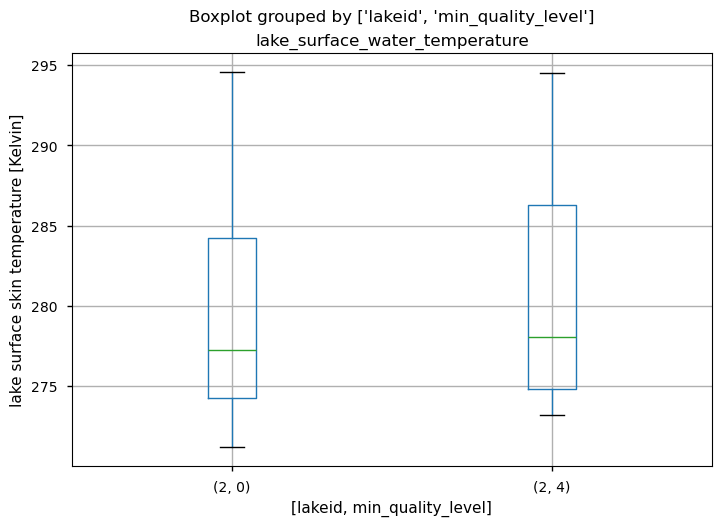

2            
                 0           4
mean    279.330414  280.373108
iqr       9.943016   11.474396
cilo    276.537485  277.213921
cihi    277.928182  278.881172
whishi  294.574585  294.485535
whislo  271.199982  273.166138
fliers          []          []
q1      274.277504  274.810059
med     277.232834  278.047546
q3       284.22052  286.284454

In [10]:
df = da.to_dataframe()
df.boxplot(by=(["lakeid", "min_quality_level"]))
plt.ylabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
plt.show()

# Show stats
stats = {}
for label, grouped_df in df.groupby(["lakeid", "min_quality_level"]):
    (stats[label],) = matplotlib.cbook.boxplot_stats(
        grouped_df.dropna().values.squeeze()
    )
pd.DataFrame(stats)

The boxplot analysis is a useful tool for comparing data quality based on quality flags. The boxplot statistics reveal that the higher quality level (4) data generally show slightly higher temperatures and greater variability compared to the lower quality level (0) data. Despite these differences, both datasets lack outliers, indicating that extreme values are not prevalent in either quality level.

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

Dataset documentation:

* [ATBD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800127#LSWTv4.5:AlgorithmTheoreticalBasisDocument(ATBD)-DeterminingQualityLevel): Algorithm Theoretical Basis Document (ATBD)
* [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177): Product User Guide and Specification (PUGS)


